### 분석목적

- Random Forest이용(Dicision_Tree 상위호환)

- 프로모션에 반응할 고객 예측

- 고객 데이터와 거래 데이터 통합 활용

### Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mem = pd.read_csv('/content/member.csv')
tran = pd.read_csv('/content/transaction.csv')

In [3]:
mem.head()

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0


In [5]:
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [6]:
mem.describe()

,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


In [4]:
tran.head()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


In [7]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [8]:
tran.describe()

,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


### 아이템별 평균 가격 추가(feature engineering)

In [9]:
tran['avg_price'] = tran['total_amount'] / tran['num_item']


In [10]:
tran

,id,num_item,total_amount,avg_price
0,906145,5,34000,6800.000000
1,906145,1,27000,27000.000000
2,906145,4,33000,8250.000000
3,184478,4,29000,7250.000000
4,394235,4,33000,8250.000000
...,...,...,...,...
196831,536246,5,24000,4800.000000
196832,927617,5,26000,5200.000000
196833,927617,3,22000,7333.333333
196834,927617,3,18000,6000.000000


### 데이터 합치기

In [11]:
#Groupby를 활용하여 id별 1줄로 데이터 요약
tran_mean = tran.groupby('id').mean()

In [12]:
#id별 거래 건수 확인
tran_cnt = tran['id'].value_counts()

In [13]:
#concat으로 데이터 결합
tran_df = pd.concat([tran_mean, tran_cnt], axis=1)

In [14]:
#Column이름 변경
tran_df.columns = ['num_item', 'total_amount', 'avg_price', 'count']

In [15]:
tran_df

,num_item,total_amount,avg_price,count
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


In [16]:
#join을 사용하기 위해, id를 인덱스로 설정
mem.set_index('id', inplace=True)

In [17]:
mem

,recency,zip_code,is_referral,channel,conversion
id,,,,,
906145,10,Surburban,0,Phone,0
184478,6,Rural,1,Web,0
394235,7,Surburban,1,Web,0
130152,9,Rural,1,Web,0
940352,2,Urban,0,Web,0
...,...,...,...,...,...
838295,10,Urban,0,Web,0
547316,5,Urban,1,Phone,0
131575,6,Urban,1,Phone,0


In [19]:
#join으로 데이터 합치기
mem.join(tran_df)

,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price,count
id,,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667,3
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000,1
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000,2
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000,4
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333,1
...,...,...,...,...,...,...,...,...,...
838295,10,Urban,0,Web,0,3.500000,26000.000000,8012.500000,4
547316,5,Urban,1,Phone,0,1.800000,17800.000000,11300.000000,5
131575,6,Urban,1,Phone,0,4.000000,30500.000000,7833.333333,2


In [20]:
data = mem.join(tran_df)

In [21]:
data

,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price,count
id,,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667,3
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000,1
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000,2
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000,4
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333,1
...,...,...,...,...,...,...,...,...,...
838295,10,Urban,0,Web,0,3.500000,26000.000000,8012.500000,4
547316,5,Urban,1,Phone,0,1.800000,17800.000000,11300.000000,5
131575,6,Urban,1,Phone,0,4.000000,30500.000000,7833.333333,2


### Missing Value확인

In [22]:
data.isna().sum() / len(data)

recency         0.0
zip_code        0.0
is_referral     0.0
channel         0.0
conversion      0.0
num_item        0.0
total_amount    0.0
avg_price       0.0
count           0.0
dtype: float64

### 카테고리 데이터 처리

In [23]:
data['zip_code'].nunique()

3

In [24]:
data['zip_code'].unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [25]:
data['channel'].nunique()

3

In [26]:
data['channel'].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [28]:
data = pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first=True)

In [29]:
data

,recency,is_referral,conversion,num_item,total_amount,avg_price,count,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
id,,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,3,1,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,1,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,2,1,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,4,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,4,0,1,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,5,0,1,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,2,0,1,1,0


### Random Forest 모델 만들기


In [30]:
from sklearn.model_selection import train_test_split


In [31]:
X_train,X_test, y_train, y_test = train_test_split(data.drop('conversion', axis=1), data['conversion'], test_size=0.3,random_state=100)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
model = RandomForestClassifier(max_depth=10, random_state=100)

In [34]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=100)

### 예측 및 평가

In [35]:
pred = model.predict(X_test)

In [36]:
y_test

id
632233    0
412308    0
184792    0
546903    0
113517    0
         ..
629047    0
470260    0
673575    0
345057    0
182726    0
Name: conversion, Length: 19200, dtype: int64

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [38]:
accuracy_score(y_test, pred)

0.87515625

In [39]:
confusion_matrix(y_test, pred)

array([[16403,    60],
       [ 2337,   400]])

In [40]:
from sklearn.metrics import classification_report


#### Classification_report의 요소

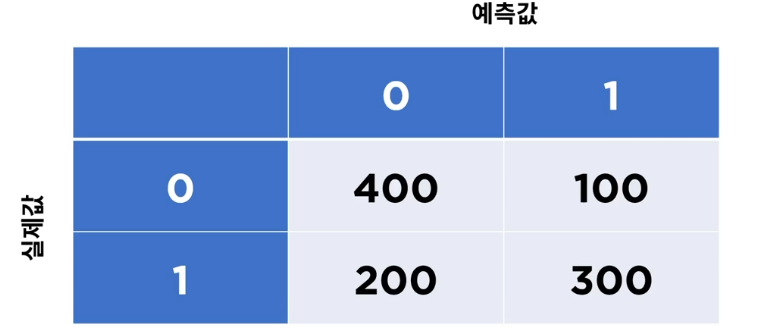

**Accurcay**

- 맞춘 케이스(0.0, 1.1) / 전체 

<br>

**Precision**

- 1이라고 예측한 것 중에서 실제 1인거

- (1,1) / (1,0) + (1,1)

<br>

**Recall**

- 실제 1인 것 중에서 예측값이 1인거

- (1,1) / (0,1) + (1,1)

- 의료 판단에서 자주 쓰임

<br>

**F1 score**

- Recall과 Precision 중 무엇이 중요한지 모를 때 이용

- 식

   - F1 = 2 X (Precision X Recall) / (Precision + Recall)

In [41]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     16463
           1       0.87      0.15      0.25      2737

    accuracy                           0.88     19200
   macro avg       0.87      0.57      0.59     19200
weighted avg       0.87      0.88      0.83     19200



### Random Forest Regressor로 확률 예측하기

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
rf = RandomForestClassifier(max_depth=10, random_state=100)

In [46]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, random_state=100)

In [47]:
pred = rf.predict(X_test)

In [48]:
pd.DataFrame(pred)

,0
0,0
1,0
2,0
3,1
4,0
...,...
19195,0
19196,0
19197,0
19198,0


In [49]:
y_test

id
632233    0
412308    0
184792    0
546903    0
113517    0
         ..
629047    0
470260    0
673575    0
345057    0
182726    0
Name: conversion, Length: 19200, dtype: int64

#### 0~1사이의 연속형 변수를 0과1로 변환

In [50]:
#방법1

def conv(x):
    if x>=0.5:
        return 1
    else:
        return 0

In [51]:
pd_result = pd.Series(pred).apply(lambda x:conv(x))

In [52]:
pd_result

0        0
1        0
2        0
3        1
4        0
        ..
19195    0
19196    0
19197    0
19198    0
19199    0
Length: 19200, dtype: int64

In [54]:
#방법2
result = []
for i in pred:
    result.append(conv(i))

In [ ]:
result

In [58]:
result_comp = [1 if x>=0.5 else 0 for x in pred]

### 평가

In [59]:
accuracy_score(y_test, result_comp)

0.87515625

In [60]:
confusion_matrix(y_test, result_comp)

array([[16403,    60],
       [ 2337,   400]])

In [62]:
print(classification_report(y_test, result_comp))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     16463
           1       0.87      0.15      0.25      2737

    accuracy                           0.88     19200
   macro avg       0.87      0.57      0.59     19200
weighted avg       0.87      0.88      0.83     19200



### 파라미터 변경해보기

In [67]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 10, random_state = 100)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8799479166666667

In [68]:
rf = RandomForestRegressor(max_depth = 12, random_state = 100)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8805729166666667

In [69]:
#n_estimators : 트리의 갯수, 꼭 다다익선은 아님
#min_samples_leaf : 오버피팅 방지이고 트리의 갯수가 된다면 종료
rf = RandomForestRegressor(n_estimators = 100 , max_depth = 12, random_state = 100, min_samples_leaf = 5)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8810416666666666

### 변수 중요성 확인

In [70]:
rf.feature_importances_

array([0.06390282, 0.0229547 , 0.31878145, 0.15857333, 0.25092914,
       0.14468844, 0.00936383, 0.00914032, 0.01179997, 0.009866  ])

In [71]:
X_train.columns

Index(['recency', 'is_referral', 'num_item', 'total_amount', 'avg_price',
       'count', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone',
       'channel_Web'],
      dtype='object')

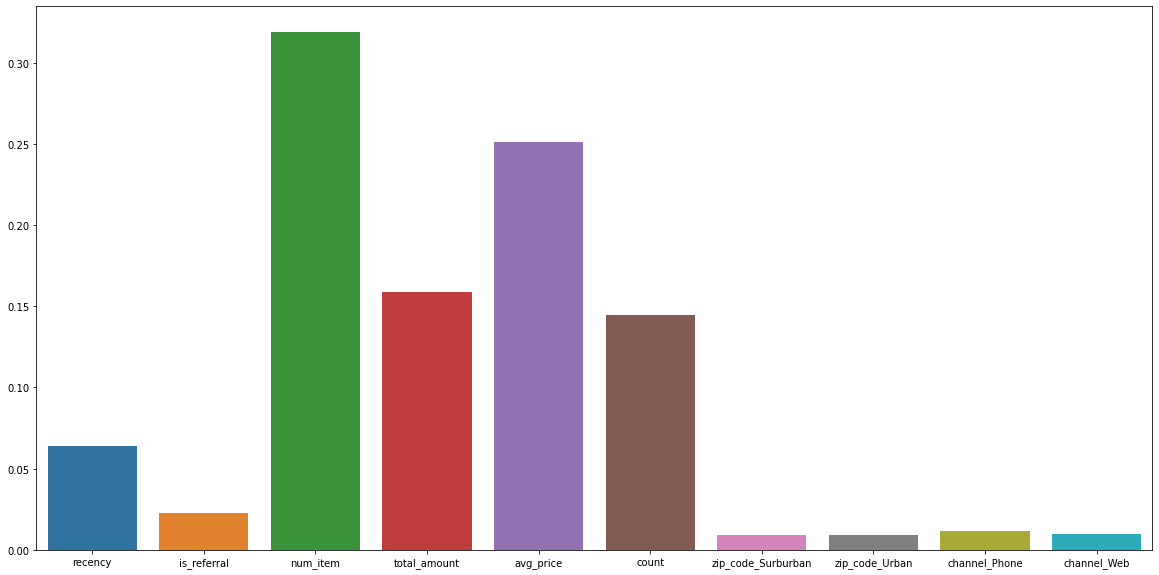

In [72]:
plt.figure(figsize=(20,10))
sns.barplot(x=X_train.columns, y = rf.feature_importances_)